In [1]:
# RealSense Setup#
import pyrealsense2 as rs
import numpy as np
import cv2
from matplotlib import pyplot as plt
from utils_sim2real import *
from Pose_Estimation_Class import *

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.rgb8, 30)

# Start streaming
cfg = pipeline.start(config)
align = rs.align(rs.stream.color)

# Get camera instrinsics
color_profile = cfg.get_stream(rs.stream.color, 0)
intr = color_profile.as_video_stream_profile().get_intrinsics()

fx, fy, height, width = intr.fx, intr.fy, intr.height, intr.width
cx, cy = intr.ppx, intr.ppy
K_rs = np.array([[fx, 0, cx],
               [0, fy, cy],
               [0, 0, 1]])
D_rs = 0

RuntimeError: No device connected

In [ ]:
CHECKERBOARD = (6, 9)
def get_frames(pipeline):
    frames = pipeline.wait_for_frames()
    frames = align.process(frames)
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    if not depth_frame or not color_frame:
        return None, None

    # Convert images to numpy arrays
    depth_image = np.asanyarray(depth_frame.get_data()) * 0.001
    color_image = np.asanyarray(color_frame.get_data())
    return color_image, depth_image

def get_cam_theta_p(color, show_img=True):
    objpoints_rs, corners_rs = get_chessboard_corners(color)
    err_value, R_vec_cam_to_chess, p_cam_to_chess = cv2.solvePnP(objpoints_rs, corners_rs, K_rs, D_rs)
    img = cv2.drawChessboardCorners(np.array(color), CHECKERBOARD, corners_rs, True)
    if show_img:
        plt.imshow(img)
        plt.show()
    return R_vec_cam_to_chess, p_cam_to_chess

def get_cam_R_T(color, show_img=True):
    objpoints_rs, corners_rs = get_chessboard_corners(color)
    img = cv2.drawChessboardCorners(np.array(color), CHECKERBOARD, corners_rs, True)
    if show_img:
        plt.imshow(img)
        plt.show()
    err_value, R_vec_cam_to_chess, p_cam_to_chess = cv2.solvePnP(objpoints_rs, corners_rs, K_rs, D_rs)
    R_cam_to_chess, _ = cv2.Rodrigues(R_vec_cam_to_chess)
    T_cam_to_chess = form_T(R_cam_to_chess, p_cam_to_chess)
    return R_cam_to_chess, T_cam_to_chess

In [ ]:
rospy.sleep(0.5)
img, _ = get_frames(pipeline)
R, T = get_cam_R_T(img)
print(np.linalg.inv(T))

In [4]:
# moveit planner
import numpy as np
import rospy
import moveit_commander
import moveit_msgs.msg
import geometry_msgs.msg
from std_msgs.msg import String

# robotiq gripper
import pyRobotiqGripper

try:
    from math import pi, tau, dist, fabs, cos
except:
    from math import pi, fabs, cos, sqrt

    tau = 2.0 * pi

    def dist(p, q):
        return sqrt(sum((p_i - q_i) ** 2.0 for p_i, q_i in zip(p, q)))


from std_msgs.msg import String
from moveit_commander.conversions import pose_to_list

ARM_JOINT_NAME = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
ROBOT_INIT_POS = [0.0, -0.4, 0.6] #[0.0, -0.3, 0.65]
ROBOT_INIT_ROTATION = np.array([[1., 0., 0.], [0., -1., 0.], [0., 0., -1.]])

# init node
rospy.init_node("test", anonymous=True)

robot = moveit_commander.RobotCommander()
scene = moveit_commander.PlanningSceneInterface()

move_group = moveit_commander.MoveGroupCommander("manipulator")


# init gripper
gripper_controller = pyRobotiqGripper.RobotiqGripper()
gripper_controller.activate()

# gripper open
# gripper_controller.open()

# gripper close
# gripper_controller.close()

Failed to import pyassimp, see https://github.com/moveit/moveit/issues/86 for more info


[ WARN] [1727683179.672977058]: IK plugin for group 'manipulator' relies on deprecated API. Please implement initialize(RobotModel, ...).


Activation completed. Activation time :  1.1203696727752686


In [5]:
from transform_utils import quat_multiply, quat2mat
# ik solver
import sys
sys.path.append('/home/ur-plusle/Desktop/ikfastpy')
import ikfastpy

In [13]:
def get_joint_states():
    return move_group.get_current_joint_values()

def get_eef_pose():
    pose = move_group.get_current_pose().pose
    position = [pose.position.x, pose.position.y, pose.position.z]
    quaternion = [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w]
    return position, quaternion

def get_view(goal_pos=None, quat=[1, 0, 0, 0], grasp=0.0, show_img=False):
    # quat: xyzw
    # quat_multiply(
    if goal_pos is not None:
        is_feasible = False
        while not is_feasible:
            pose_goal = geometry_msgs.msg.Pose()
            pose_goal.orientation.x = quat[0]
            pose_goal.orientation.y = quat[1]
            pose_goal.orientation.z = quat[2]
            pose_goal.orientation.w = quat[3]
            pose_goal.position.x = goal_pos[0]
            pose_goal.position.y = goal_pos[1]
            pose_goal.position.z = goal_pos[2]
            move_group.set_pose_target(pose_goal)
            res = move_group.plan()
    
            traj_length = len(res[1].joint_trajectory.points)
            print("Trajectory:", traj_length)
            # check success
            if res[0] is False:
                print("Failed planning to the goal")
                #return None, None
            elif traj_length>7:
                print("A wrong path is obtained")
                #return None, None
            else:
                print("Find a feasible trajectory")
                is_feasible = True
        # move to the view
        move_group.execute(res[1], wait=True)
        
    # gripper control
    if grasp > 0.0:
        gripper_controller.close()
        # suction gripper grasping
        # gripper_controller.grasp()
    else:
        gripper_controller.open()
    
    rospy.sleep(0.5)
    if show_img:
        color, depth = get_frames(pipeline)
        # plt.imshow(color)
        # plt.show()
        return color, depth
    return None, None

In [8]:
pose, quat = get_eef_pose()
print('pose:', pose)
print('quat:', quat)

pose: [0.04849810228678374, -0.3467360000059334, 0.7775309898671068]
quat: [0.9673450867865593, -0.2503275234145303, -0.030853872205419807, 0.025052997045930857]


Trajectory: 2
Find a feasible trajectory


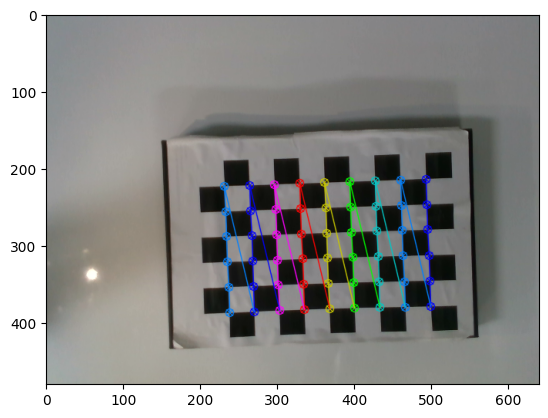

[[ 0.03589077  0.99906108 -0.02426557 -0.03206194]
 [-0.99906648  0.03645395  0.02317914  0.01943223]
 [ 0.02404195  0.02341101  0.9994368  -0.46600976]
 [ 0.          0.          0.          1.        ]]


In [12]:
img, _ = get_view(ROBOT_INIT_POS, grasp=0.0, show_img=True) # grasp=1.0
R, T = get_cam_R_T(img)
print(np.linalg.inv(T))

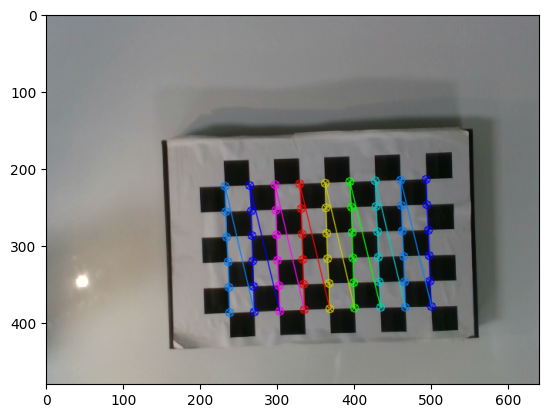

pose: [9.460010943146181e-05, -0.39998751489805634, 0.6000461181205022]
quat: [-0.9999998890356603, 0.00033393418586806164, 3.0889466003350134e-05, 0.0003308511257811286]


In [14]:
img, _ = get_view(grasp=0.0, show_img=True) # grasp=1.0
R, T = get_cam_R_T(img)
pose, quat = get_eef_pose()
print('pose:', pose)
print('quat:', quat)

In [15]:
calib_positions = np.array([
    [0.0, -0.4, 0.6],
    [0.16221302792868142, -0.2284722428475187, 0.5948368282567269],
    [0.2012740432258835, -0.39265389183932337, 0.6359119812308631],
    [0.09932295699706221, -0.05365789392184143, 0.8030877270291297],
    [-0.05196368964658435, -0.32783010022564624, 0.6676983184012777],
    [-0.10486410027270285, -0.5043237730083063, 0.5405152469790242]
    #[-0.10318058064003063, -0.4357829380525802, 0.6626924601174065],
    #[-0.11304694304198157, -0.28294087048227967, 0.6718131681472418]
    ])
# xyzw quaternion
calib_quaternions = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.9460626450590898, 0.27516303233243933, -0.1558303055747744, 0.0704818638082726],
    [-0.9619432637793055, -0.1903954557992267, 0.19408669216685676, 0.02729621959813964],
    [0.959837833284027, -0.08432064430649856, -0.060277526329869324, 0.2607066983410922],
    [0.9736692127942503, -0.21980489278183749, 0.058831424420886715, 0.01389016437624522],
    [-0.9689119342688051, 0.14715283064432685, -0.1298279981563769, 0.15066651572115353]
    #[-0.9756752972212775, 0.20864617351694806, -0.053564094336018477, 0.040686317932069054],
    #[0.934029904309261, -0.3458862203599112, 0.08909999649295618, 0.003471461669490207]
    ])

Trajectory: 2
Find a feasible trajectory


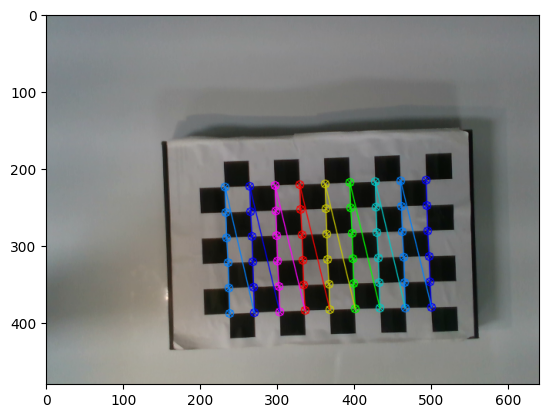

Trajectory: 4
Find a feasible trajectory


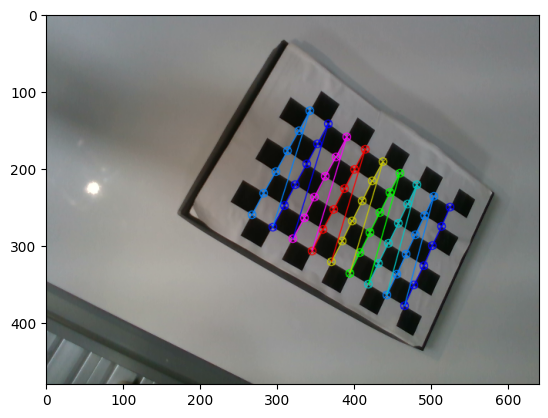

Trajectory: 4
Find a feasible trajectory


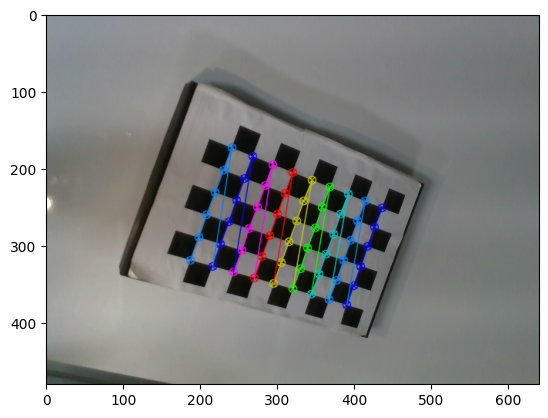

Trajectory: 4
Find a feasible trajectory


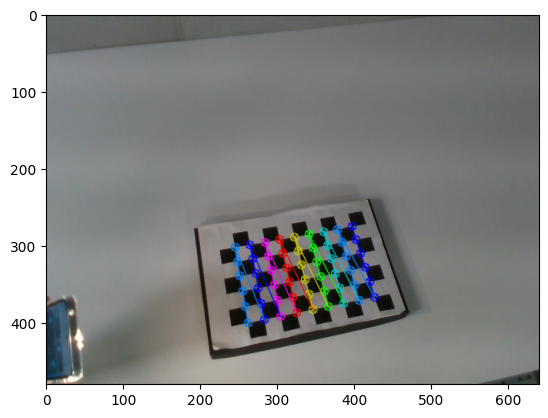

Trajectory: 4
Find a feasible trajectory
Trajectory: 3
Find a feasible trajectory


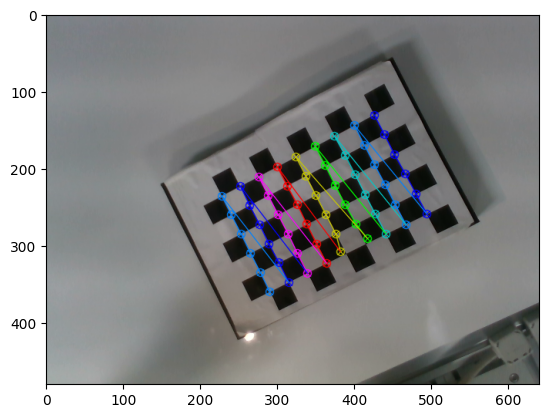

Trajectory: 3
Find a feasible trajectory


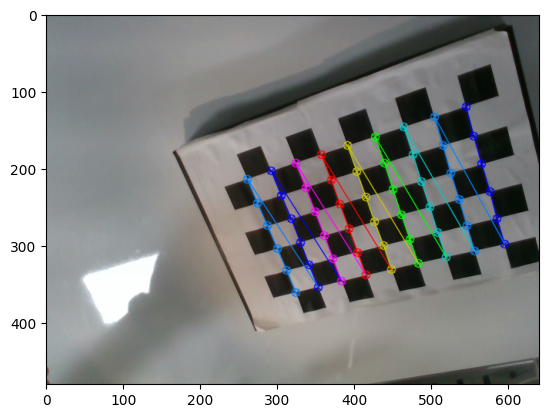

Trajectory: 3
Find a feasible trajectory


In [17]:
T_realsense = []
T_ur5 = []

ct = 0
for p, q in zip(calib_positions, calib_quaternions):
    if ct==4:
        img, _ = get_view(ROBOT_INIT_POS, grasp=0.0, show_img=False)
        rospy.sleep(0.5)
    
    img, _ = get_view(p, q, show_img=True)
    R, T_cam_to_chess = get_cam_R_T(img)
    T_chess_to_cam = np.linalg.inv(T_cam_to_chess)
    
    q_wxyz = [q[3], q[0], q[1], q[2]]
    T_base_to_eef = form_T(quaternion_matrix(q_wxyz)[:3, :3], p)
    
    T_realsense.append(T_chess_to_cam)
    T_ur5.append(T_base_to_eef)
    rospy.sleep(1.0)
    ct += 1

img, _ = get_view(ROBOT_INIT_POS)

In [18]:
T_realsense

[array([[ 0.03597112,  0.9990283 , -0.02546633, -0.0324444 ],
        [-0.9990454 ,  0.03658042,  0.02387824,  0.01921244],
        [ 0.02478661,  0.0245831 ,  0.99939046, -0.46608917],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-0.46846799,  0.85991374, -0.2026971 ,  0.12674525],
        [-0.82098461, -0.50847358, -0.25968999,  0.19019737],
        [-0.32637711,  0.04475475,  0.94417954, -0.45367915],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-0.34203817,  0.93954987, -0.01599774, -0.02274632],
        [-0.86317517, -0.32087206, -0.38983297,  0.21494457],
        [-0.37140074, -0.11952891,  0.92074661, -0.48538231],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.220751  ,  0.85867853, -0.46253669,  0.24835043],
        [-0.97323092,  0.16283221, -0.16219508,  0.11580945],
        [-0.06395756,  0.48595973,  0.87163787, -0.70324957],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),


In [19]:
# form A, B matrix
A = []
B = []

for i, Ti in enumerate(T_ur5):
    for j, Tj in enumerate(T_ur5):
        if i==j: continue
        A.append(np.linalg.inv(Ti).dot(Tj))
        
for i, Ti in enumerate(T_realsense):
    for j, Tj in enumerate(T_realsense):
        if i==j: continue
        B.append(np.linalg.inv(Ti).dot(Tj))
        #A.append(Ti.dot(np.linalg.inv(Tj)))

A = np.array(A).transpose([1,2,0])
B = np.array(B).transpose([1,2,0])

+ Simultaneous Robot/World and Tool/Flange Calibration:    
Implementation of Shah, Mili. "Solving the robot-world/hand-eye calibration problem using the Kronecker product." 
Journal of Mechanisms and Robotics 5.3 (2013): 031007.

Batch_Processing solvesfor  X and Y in AX=YB from a set of (A,B) paired measurements.
(Ai,Bi) are absolute pose measurements with known correspondance       
A: (4x4xn) 
X: (4x4): unknown
Y: (4x4): unknown
B: (4x4xn) 
n number of measurements

+ EKF,IEKF solves for AX=XB from a set of (Ai,Bi) relative pose measurements with known correspondance.
so3 representation was used to represent the state of rotation.  

In [20]:
def get_error(T_rs_to_eef):
    error = 0
    for i in range(A.shape[-1]):
        err = np.linalg.norm(A[:,:,i].dot(T_rs_to_eef) - T_rs_to_eef.dot(B[:,:,i]))
        error += err
    return error

In [21]:
T_eef_to_rs = LeastSquaresAXXB(A.transpose([2, 0, 1]), B.transpose([2, 0, 1]), verbose=True)

print(T_eef_to_rs)
print('------------------------------')
print('Quat:', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_quat())
print('Euler(degree):', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_euler('zyx', degrees=True))
print('------------------------------')
print('Error:', get_error(T_eef_to_rs))

RotX: [[-0.99995231 -0.00748196 -0.00627649]
 [ 0.00760298 -0.99978124 -0.0194849 ]
 [-0.00612933 -0.01953169  0.99979045]]
tX: [0.04636897 0.05496415 0.08598002]
[[-0.99995231 -0.00748196 -0.00627649  0.04636897]
 [ 0.00760298 -0.99978124 -0.0194849   0.05496415]
 [-0.00612933 -0.01953169  0.99979045  0.08598002]
 [ 0.          0.          0.          1.        ]]
------------------------------
Quat: [-0.00310164 -0.00975473  0.9999405   0.00377146]
Euler(degree): [179.57130309  -0.35961887   1.11649511]
------------------------------
Error: 1.1704274212973385


In [22]:
np.save('rs_extrinsic.npy', T_eef_to_rs)

In [23]:
T_eef_to_rs

array([[-0.99995231, -0.00748196, -0.00627649,  0.04636897],
       [ 0.00760298, -0.99978124, -0.0194849 ,  0.05496415],
       [-0.00612933, -0.01953169,  0.99979045,  0.08598002],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

### Other Solvers

In [22]:
#UKF
ukf=UKF()
for i in range(len(A[1,1,:])):
    AA=A[:,:,i] 
    BB=B[:,:,i]
    ukf.Update(AA,BB)

theta=np.linalg.norm(ukf.x[:3])
if theta < EPS:
    k=[0,1,0] #VRML standard
else:
    k=ukf.x[0:3]/np.linalg.norm(ukf.x[:3])
euler_ukf=Tools.mat2euler(Tools.vec2rotmat(theta, k))
print('.....UKF Results')

# print(euler_iekf)
print('Euler:', np.array(euler_ukf)*180/np.pi)
print('Translation:', ukf.x[3:])
print('------------------------------')
T_eef_to_rs = form_T(Tools.vec2rotmat(theta, k), ukf.x[3:])
print(T_eef_to_rs)

print('------------------------------')
print('Quat:', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_quat())
print('Euler(degree):', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_euler('zyx', degrees=True))
print('------------------------------')
print('Error:', get_error(T_eef_to_rs))

NameError: name 'BB' is not defined

In [55]:
#IEKF
iekf=IEKF()
for i in range(len(A[1,1,:])):
    AA=A[:,:,i] 
    BB=B[:,:,i]
    iekf.Update(AA,BB)
    
theta=np.linalg.norm(iekf.x[:3])
if theta < EPS:
    k=[0,1,0] #VRML standard
else:
    k=iekf.x[0:3]/np.linalg.norm(iekf.x[:3])
euler_iekf=Tools.mat2euler(Tools.vec2rotmat(theta, k))

print('IEKF Results')

# print(euler_iekf)
print('Euler:', np.array(euler_iekf)*180/np.pi)
print('Translation:', iekf.x[3:])
print('------------------------------')
T_eef_to_rs = form_T(Tools.vec2rotmat(theta, k), iekf.x[3:])
print(T_eef_to_rs)

print('------------------------------')
print('Quat:', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_quat())
print('Euler(degree):', Rotation.from_matrix(T_eef_to_rs[:3,:3]).as_euler('zyx', degrees=True))
print('------------------------------')
print('Error:', get_error(T_eef_to_rs))

IEKF Results
Euler: [ 81.70754853  62.79862419 -93.32386478]
Translation: [ 0.29129234 -0.15536599  0.85344149]
------------------------------
[[ 0.06592841 -0.45234001  0.8894054   0.29129234]
 [-0.1854331   0.87026374  0.4563503  -0.15536599]
 [-0.98044276 -0.19501165 -0.02650371  0.85344149]
 [ 0.          0.          0.          1.        ]]
------------------------------
Quat: [-0.2356737   0.6765425   0.09657141  0.69095739]
Euler(degree): [ 81.70754853  62.79862419 -93.32386478]
------------------------------
Error: 24.283159596213654


In [58]:
A[:,:,0].dot(T_eef_to_rs)

array([[-0.97868181, -0.01606579, -0.20475305,  0.28732745],
       [ 0.00479947, -0.99845258,  0.05540223,  0.19685594],
       [-0.20532629,  0.05323845,  0.97724448,  0.06034868],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [59]:
T_eef_to_rs.dot(B[:,:,0])

array([[-0.97927247, -0.01972596, -0.20158453,  0.28912087],
       [-0.00391292, -0.9932182 ,  0.1161994 ,  0.16041718],
       [-0.20250957,  0.11457965,  0.97255405,  0.06585868],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [163]:
T_test = np.eye(4)
T_test[:3,:3] = Rotation.from_euler('zx', [180, 180], degrees=True).as_matrix()
print(T_test)
get_error(T_test)

[[-1.00000000e+00 -1.22464680e-16  0.00000000e+00  0.00000000e+00]
 [-1.22464680e-16  1.00000000e+00 -1.22464680e-16  0.00000000e+00]
 [ 1.49975978e-32 -1.22464680e-16 -1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


30.005158398839626

<IPython.core.display.Javascript object>


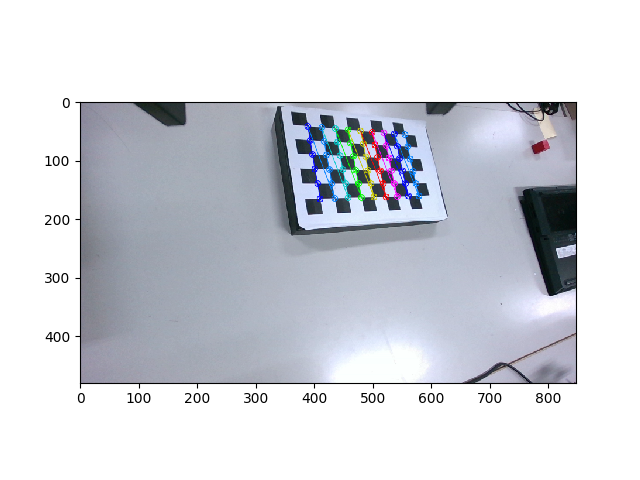

In [21]:
%matplotlib notebook
color, depth = get_view(ROBOT_INIT_POS, show_img=True)

In [18]:
goal_pixel = np.array([400, 294])
p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
print(p_rs_to_goal)

T_base_to_initeef = form_T(ROBOT_INIT_ROTATION, ROBOT_INIT_POS)

goal_position = T_base_to_initeef.dot(T_eef_to_rs.dot(np.concatenate([p_rs_to_goal, [1]])))[:3]
print(goal_position)

[-0.02360692  0.05519219  0.53200001]
[-0.00689674 -0.41961517  0.05004328]


In [19]:
def move_to_pixel(depth, goal_pixel):
    p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
    print(p_rs_to_goal)
    
    T_base_to_initeef = form_T(ROBOT_INIT_ROTATION, ROBOT_INIT_POS)
    T_rs_to_goal = form_T(np.eye(3), p_rs_to_goal)

    T_base_to_goal = T_base_to_initeef.dot(T_eef_to_rs.dot(T_rs_to_goal))    
    
    goal_position = T_base_to_goal[:3, 3]
    goal_position[2] = np.clip(goal_position[2], 0.2, 0.8)
    print(goal_position)
    _ = get_view(goal_position)

In [20]:
goal_pixel = np.array([400, 294])
move_to_pixel(depth, goal_pixel)

[-0.02360692  0.05519219  0.53200001]
[-0.00689674 -0.41961517  0.2       ]


In [10]:
T_eef_to_rs = np.load('rs_extrinsic.npy')

In [22]:
move_to_pixel(depth, np.array([374, 189]))

[-0.05127966 -0.06459054  0.634     ]
[ 0.09702317 -0.44974024  0.2       ]


In [33]:
T_eef_to_rs = np.load('rs_extrinsic.npy')

In [11]:
X_MIN = -0.5
X_MAX = 0.5
Y_MIN = -0.85
Y_MAX = -0.3
Z_MIN = 0.18
Z_MAX = 0.8

In [12]:
X_WS_MIN = -0.3
X_WS_MAX = 0.3
Y_WS_MIN = -0.75
Y_WS_MAX = -0.35
Z_WS_MIN = 0.19
Z_WS_MAX = 0.25
ROBOT_WS_INIT = [0, -0.5, 0.65]

In [13]:
ROBOT_WS_INIT

[0, -0.5, 0.65]

In [14]:
pos = ROBOT_WS_INIT #[0.0, -0.5, 0.6]
quat = [1, 0, 0, 0]
grasp = 1.0
_ = moveUR5(ARM_JOINT_NAME, None, pos, quat, 1-grasp)

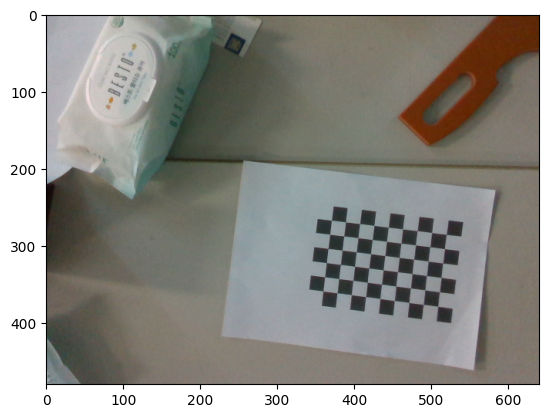

In [38]:
color, depth = get_view(None, show_img=True)
plt.imshow(color)

In [16]:
def pixel2pose(depth, robot_pose, goal_pixel):
    p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
    
    T_base_to_initeef = form_T(ROBOT_INIT_ROTATION, robot_pose)
    T_rs_to_goal = form_T(np.eye(3), p_rs_to_goal)

    T_base_to_goal = T_base_to_initeef.dot(T_eef_to_rs.dot(T_rs_to_goal))    
    
    goal_position = T_base_to_goal[:3, 3]
    goal_position[2] = np.clip(goal_position[2], 0.2, 0.8)
    print(goal_position)

In [174]:
pixel2pose(depth, ROBOT_WS_INIT, np.array([420,0]))
pixel2pose(depth, ROBOT_WS_INIT, np.array([420,479]))

[ 0.04677166 -0.85078092  0.2       ]
None
[ 0.05330331 -0.34255276  0.2       ]
None


In [165]:
img, _ = get_view(None)
# get_cam_R_T(img)
pos, quat = get_eef_pose()
print([np.round(p, 3) for p in pos])
print([np.round(q, 4) for q in quat])

[-0.0, -0.45, 0.65]
[1.0, -0.0001, -0.0, 0.0]
